In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import time

In [2]:
torch.device('cpu')

device(type='cpu')

In [3]:
# Define a function to load training and testing data
def load_data():
    # Define a transform to convert the input data into a PyTorch tensor.
    # transforms.Compose allows combining multiple transformations, here we use only ToTensor.
    transform = transforms.Compose([transforms.ToTensor()])
    
    # Load the KMNIST training dataset.
    # - 'root' specifies the directory to store the data.
    # - 'train = True' indicates that this is the training set.
    # - 'download = True' ensures that the dataset is downloaded if it's not already present.
    # - 'transform' applies the transformation defined above to each image.
    dataset = datasets.KMNIST(root = './data', train = True, download = True, transform = transform)
    
    # Load the KMNIST testing dataset.
    # - 'train = False' indicates that this is the test set.
    test_dataset = datasets.KMNIST(root = './data', train = False, download = True, transform = transform)
    
    # Return both the training and testing datasets as a tuple.
    return dataset, test_dataset

# Call the load_data function to get the datasets and assign them to variables.
dataset, test_dataset = load_data()

# Define the batch size for training.
# This determines the number of samples that will be processed together in one iteration.
batch_size = 64

# Set the number of training epochs.
# An epoch represents one complete pass through the entire training dataset.
epochs = 10

# Define the learning rate for the optimizer.
# This value controls how much the weights are updated during each step of the training process.
learning_rate = 0.001

In [4]:
# Define a FeedForward Neural Network class that inherits from PyTorch's nn.Module.
class FeedForwardNN(nn.Module):
    
    # The constructor for the neural network.
    def __init__(self):
        # Initialize the parent class (nn.Module)
        super(FeedForwardNN, self).__init__()
        
        # Define the first fully connected layer:
        # This layer takes a flattened 28x28 image (784 features) and outputs 128 features.
        self.fc1 = nn.Linear(28 * 28, 128)
        
        # Define the second fully connected layer:
        # This layer takes the 128 features from the previous layer and outputs 64 features.
        self.fc2 = nn.Linear(128, 64)
        
        # Define the third fully connected layer:
        # This layer takes the 64 features and outputs 10 features (one for each class).
        self.fc3 = nn.Linear(64, 10)
        
        # Define the ReLU activation function for introducing non-linearity.
        self.relu = nn.ReLU()
        
        # Define the Softmax activation function to convert outputs into probabilities.
        # 'dim = 1' specifies that softmax is applied along the feature dimension.
        self.softmax = nn.Softmax(dim = 1)
    
    # The forward pass defines how data flows through the network.
    def forward(self, x):
        # Reshape the input tensor x to have a shape of (batch_size, 28 * 28).
        # This flattens each 28x28 image into a 1D vector.
        x = x.view(-1, 28 * 28)
        
        # Apply the first fully connected layer followed by ReLU activation.
        x = self.relu(self.fc1(x))
        
        # Apply the second fully connected layer followed by ReLU activation.
        x = self.relu(self.fc2(x))
        
        # Apply the third fully connected layer, then apply Softmax to obtain class probabilities.
        x = self.softmax(self.fc3(x))
        
        # Return the final output probabilities.
        return x


In [5]:
# Define a function to train and evaluate the model using a specified optimizer.
def train_and_evaluate(optimizer_name):
    # Initialize a dictionary to store metrics for training and evaluation.
    # 'train_loss' and 'test_loss' will keep track of loss per epoch,
    # 'train_acc' and 'test_acc' will record the accuracy,
    # and 'time' will store the elapsed time for each fold.
    results = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'time': []}
    
    # Set the number of folds for cross-validation.
    k_folds = 5
    
    # Create a KFold cross-validator with shuffling enabled and a fixed random state for reproducibility.
    kf = KFold(n_splits = k_folds, shuffle = True, random_state = 42)
    
    # Iterate over each fold generated by KFold.
    # 'kf.split(dataset)' returns indices for training and validation subsets.
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f'Fold {fold + 1}/{k_folds}')
        
        # Create subsets for training and validation using the indices provided by KFold.
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)
        
        # Create DataLoader objects for the training and validation subsets.
        # The training loader shuffles data for each epoch, while the validation loader does not.
        train_loader = DataLoader(train_subset, batch_size = batch_size, shuffle = True)
        val_loader = DataLoader(val_subset, batch_size = batch_size, shuffle = False)
        
        # Initialize a new instance of the FeedForward Neural Network model.
        model = FeedForwardNN()
        
        # Define the loss function (criterion) for multi-class classification.
        criterion = nn.CrossEntropyLoss()
        
        # Choose the optimizer based on the provided optimizer_name argument.
        # The optimizer updates model parameters based on the computed gradients.
        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr = learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr = learning_rate)
        elif optimizer_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr = learning_rate)
        
        # Record the starting time for the current fold to later compute elapsed time.
        start_time = time.time()
        
        # Loop over the number of epochs for training.
        for epoch in range(epochs):
            # Set the model to training mode to ensure that layers like dropout or batch norm behave accordingly.
            model.train()
            
            # Initialize cumulative training loss and count of correctly classified samples.
            train_loss, correct = 0, 0
            
            # Iterate over the training data in batches.
            for images, labels in train_loader:
                # Zero the gradients for the optimizer to avoid accumulation.
                optimizer.zero_grad()
                
                # Forward pass: Compute model predictions for the current batch.
                outputs = model(images)
                
                # Compute the loss between predictions and actual labels.
                loss = criterion(outputs, labels)
                
                # Backward pass: Compute gradients for each parameter.
                loss.backward()
                
                # Update model parameters using the optimizer.
                optimizer.step()
                
                # Accumulate the loss value for reporting.
                train_loss += loss.item()
                
                # Count the number of correct predictions in the batch.
                correct += (outputs.argmax(dim=1) == labels).sum().item()
            
            # Compute the average training loss over all batches.
            train_loss /= len(train_loader)
            # Compute training accuracy as the ratio of correctly predicted samples to total samples.
            train_acc = correct / len(train_loader.dataset)
            
            # Set the model to evaluation mode to disable dropout and other training-specific behavior.
            model.eval()
            
            # Initialize cumulative validation loss and correct prediction counter.
            val_loss, correct = 0, 0
            
            # Evaluate the model on the validation data without computing gradients.
            with torch.no_grad():
                for images, labels in val_loader:
                    # Forward pass: Compute model predictions.
                    outputs = model(images)
                    
                    # Compute the loss on the validation batch.
                    loss = criterion(outputs, labels)
                    
                    # Accumulate the loss.
                    val_loss += loss.item()
                    
                    # Count correct predictions.
                    correct += (outputs.argmax(dim=1) == labels).sum().item()
            
            # Compute the average validation loss over all batches.
            val_loss /= len(val_loader)
            # Compute validation accuracy.
            val_acc = correct / len(val_loader.dataset)
            
            # Print the metrics for the current epoch.
            print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}, Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}')
            
            # Record the metrics for this epoch into the results dictionary.
            results['train_loss'].append(train_loss)
            results['test_loss'].append(val_loss)
            results['train_acc'].append(train_acc)
            results['test_acc'].append(val_acc)
        
        # Record the elapsed time for training this fold.
        results['time'].append(time.time() - start_time)
    
    # Return the dictionary containing metrics from all folds.
    return results

In [6]:
# Define a list of optimizer names to test.
optimizers = ['Adam', 'RMSprop', 'AdamW']

# Create an empty dictionary to store the results for each optimizer.
results_dict = {}

# Iterate over each optimizer in the list.
for opt in optimizers:
    # Print a message indicating which optimizer is currently being used for training.
    print(f'Running training with {opt} optimizer...')
    
    # Train and evaluate the model using the current optimizer.
    # The function 'train_and_evaluate' will return a dictionary of performance metrics.
    # Store these metrics in 'results_dict' with the optimizer name as the key.
    results_dict[opt] = train_and_evaluate(opt)

Running training with Adam optimizer...
Fold 1/5
Epoch 1: Train Loss 1.7130, Val Loss 1.6451, Train Acc 0.7677, Val Acc 0.8203
Epoch 2: Train Loss 1.6291, Val Loss 1.6246, Train Acc 0.8356, Val Acc 0.8407
Epoch 3: Train Loss 1.6077, Val Loss 1.6095, Train Acc 0.8564, Val Acc 0.8538
Epoch 4: Train Loss 1.5938, Val Loss 1.5925, Train Acc 0.8698, Val Acc 0.8698
Epoch 5: Train Loss 1.5693, Val Loss 1.5788, Train Acc 0.8944, Val Acc 0.8842
Epoch 6: Train Loss 1.5576, Val Loss 1.5685, Train Acc 0.9059, Val Acc 0.8942
Epoch 7: Train Loss 1.5486, Val Loss 1.5701, Train Acc 0.9145, Val Acc 0.8930
Epoch 8: Train Loss 1.5443, Val Loss 1.5637, Train Acc 0.9181, Val Acc 0.8978
Epoch 9: Train Loss 1.5386, Val Loss 1.5623, Train Acc 0.9238, Val Acc 0.8988
Epoch 10: Train Loss 1.5350, Val Loss 1.5605, Train Acc 0.9273, Val Acc 0.9015
Fold 2/5
Epoch 1: Train Loss 1.7112, Val Loss 1.6445, Train Acc 0.7693, Val Acc 0.8225
Epoch 2: Train Loss 1.6338, Val Loss 1.6206, Train Acc 0.8306, Val Acc 0.8423
Epoch

In [7]:
# Define a function to plot training and testing metrics (loss and accuracy)
def plot_results(results_dict):
    # Create a new figure for the loss comparison plot with specified dimensions.
    plt.figure(figsize = (10, 5))
    
    # Loop through each optimizer in the results dictionary.
    for opt in results_dict:
        # Plot the training loss for the current optimizer.
        plt.plot(results_dict[opt]['train_loss'], label = f'{opt} Train Loss')
        # Plot the testing (or validation) loss for the current optimizer.
        plt.plot(results_dict[opt]['test_loss'], label = f'{opt} Test Loss')
    
    # Add a legend to identify each plotted line.
    plt.legend()
    # Set the title of the loss plot.
    plt.title('Loss Comparison')
    # Display the loss plot.
    plt.show()
    
    # Create a new figure for the accuracy comparison plot with specified dimensions.
    plt.figure(figsize = (10, 5))
    
    # Loop through each optimizer in the results dictionary.
    for opt in results_dict:
        # Plot the training accuracy for the current optimizer.
        plt.plot(results_dict[opt]['train_acc'], label = f'{opt} Train Accuracy')
        # Plot the testing (or validation) accuracy for the current optimizer.
        plt.plot(results_dict[opt]['test_acc'], label = f'{opt} Test Accuracy')
    
    # Add a legend to identify each plotted line.
    plt.legend()
    # Set the title of the accuracy plot.
    plt.title('Accuracy Comparison')
    # Display the accuracy plot.
    plt.show()

# Define a function to generate a table summarizing average results for each optimizer.
def generate_results_table(results_dict):
    # Initialize an empty list to store the summary data for each optimizer.
    data = []
    
    # Iterate over each optimizer's results in the results dictionary.
    for opt in results_dict:
        # Calculate the average training loss across all epochs/folds.
        avg_train_loss = np.mean(results_dict[opt]['train_loss'])
        # Calculate the average testing (or validation) loss across all epochs/folds.
        avg_test_loss = np.mean(results_dict[opt]['test_loss'])
        # Calculate the average training accuracy across all epochs/folds.
        avg_train_acc = np.mean(results_dict[opt]['train_acc'])
        # Calculate the average testing (or validation) accuracy across all epochs/folds.
        avg_test_acc = np.mean(results_dict[opt]['test_acc'])
        # Calculate the average time taken per fold.
        avg_time = np.mean(results_dict[opt]['time'])
        
        # Append a list containing the optimizer name and its computed averages to the data list.
        data.append([opt, avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc, avg_time])
    
    # Create a pandas DataFrame from the collected data with appropriate column headers.
    df = pd.DataFrame(data, columns = ['Optimizer', 'Avg Train Loss', 'Avg Test Loss', 'Avg Train Acc', 'Avg Test Acc', 'Avg Time (s)'])
    
    # Print the DataFrame to display the results table.
    print(df)
    
    # Return the DataFrame for further use if needed.
    return df

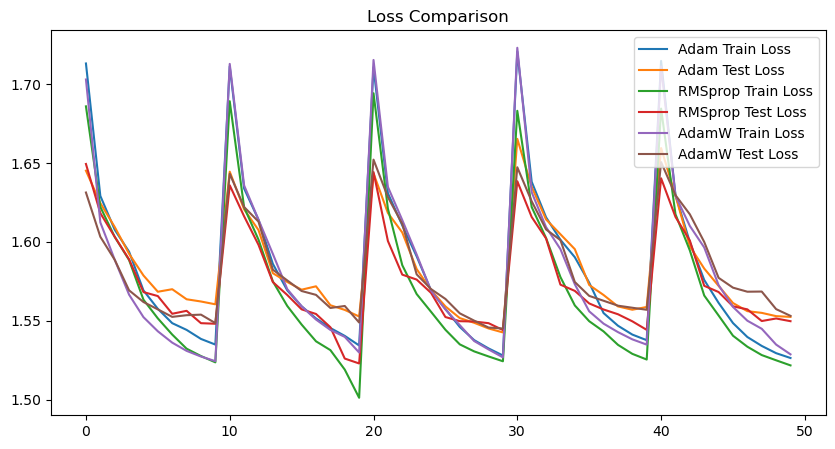

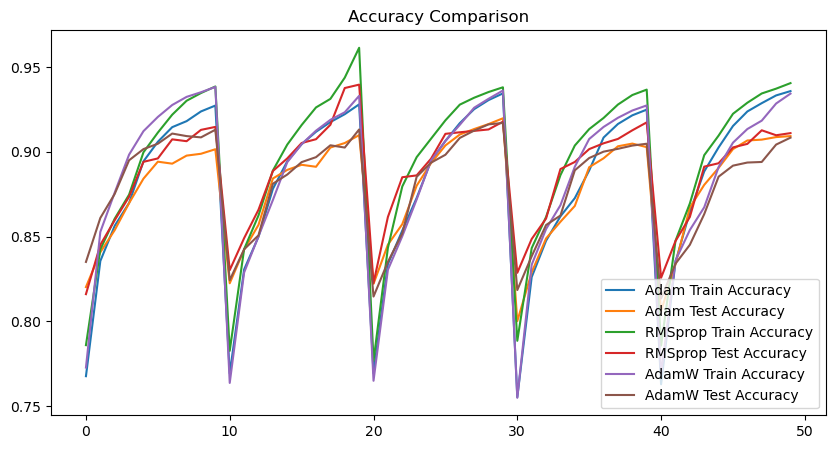

Adam Training Time: 213.26 seconds
RMSprop Training Time: 228.33 seconds
AdamW Training Time: 177.29 seconds


In [10]:
# Call the plot_results function to display plots comparing training and testing loss and accuracy for each optimizer.
plot_results(results_dict)

# Loop through each optimizer's results stored in the results_dict.
for opt in results_dict:
    # Compute the average training time for the current optimizer by taking the mean of the 'time' list.
    avg_time = np.mean(results_dict[opt]["time"])
    
    # Print the optimizer name along with its average training time,
    # formatted to two decimal places to keep the output neat.
    print(f'{opt} Training Time: {avg_time:.2f} seconds')

In [11]:
# Call the generate_results_table function to create and display a summary table.
generate_results_table(results_dict)

  Optimizer  Avg Train Loss  Avg Test Loss  Avg Train Acc  Avg Test Acc  \
0      Adam        1.583564       1.584604       0.881425      0.878518   
1   RMSprop        1.570047       1.574846       0.894057      0.888073   
2     AdamW        1.581015       1.582278       0.884151      0.880950   

   Avg Time (s)  
0    213.255673  
1    228.330604  
2    177.294926  


,Optimizer,Avg Train Loss,Avg Test Loss,Avg Train Acc,Avg Test Acc,Avg Time (s)
0,Adam,1.583564,1.584604,0.881425,0.878518,213.255673
1,RMSprop,1.570047,1.574846,0.894057,0.888073,228.330604
2,AdamW,1.581015,1.582278,0.884151,0.880950,177.294926


> The training logs across five folds and ten epochs reveal distinct performance nuances among the optimizers. All three Adam, RMSprop, and AdamW demonstrate a consistent trend of decreasing losses and increasing accuracies over time. However, differences emerge when examining the precise numbers.

### Analyzing Adam Optimizer
For Adam, the model typically started with a training loss around 1.71–1.72 in epoch 1 and converged to approximately 1.53–1.54 by epoch 10. Training accuracies steadily improved from roughly 76–77% in the first epoch to around 92–93% in later epochs, while validation accuracies reached about 90–91%. Although Adam’s performance is solid, its convergence appears a bit gradual compared to the others.

### Analyzing RMSprop Optimizer
RMSprop, in contrast, shows a slightly more aggressive reduction in loss and higher final accuracies. In some folds, RMSprop pushed the training accuracy as high as 96.13% by the final epoch, with training losses dipping below 1.52 and validation losses following a similar downward trend. These results suggest that RMSprop might be fine-tuning the model’s parameters more effectively, contributing to its superior overall performance in this task.

### Analyzing AdamW Optimizer
AdamW also exhibits competitive behavior with some noteworthy numbers. In several folds, AdamW reduced the training loss from about 1.70–1.72 at the beginning to a consistent range of 1.524–1.530 by epoch 10. For instance, in Fold 1, AdamW recorded a final training accuracy of approximately 93.82% and a validation accuracy around 91.30%. Across the folds, AdamW’s average final performance hovered near a training accuracy of 93% and validation accuracy of about 91%, with losses settling in a similar range as observed in Fold 1. While AdamW doesn’t always reach the peak performance seen with RMSprop, its steady convergence and reliable metric improvements make it a robust contender.

### Conclusion
In conclusion, RMSprop appears to outperform the others on this task by achieving the lowest losses and highest accuracies consistently. However, AdamW remains a strong alternative, delivering competitive results with stable convergence patterns and final metrics that are only marginally behind RMSprop. Depending on the specific application requirements and tolerance for variability, RMSprop might be the best choice, while AdamW also offers a dependable option for similar neural network training scenarios.

### References

https://pytorch.org/vision/main/generated/torchvision.datasets.KMNIST.html
https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html
https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html
https://pytorch.org/docs/stable/generated/torch.nn.Module.html
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html